<a href="https://colab.research.google.com/github/zfukuoka/image_visual_analysis/blob/master/image_visual_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Analysis in comparing using Gooogle Colab / Google Colaboratory用画像比較分析

This is image analysis in comparing using Google Colab.
Now, this program compares CIE 1931 xy color space between 2 images.

Google Colaboratory用の画像比較分析プログラムです。
現在は、CIE xy色度図の比較表示に特化しています。

## Requirement / 動作に必要なもの

*   Google account for use of Google Colab / Google Colaboratory を使うための Google アカウント
*   Web browther / Webブラウザ
*   2 pictures have same angle of view / 同じ画角で撮影した画像２枚

## Striction / 制限事項

*   sRGBの色空間とガンマ2.2を採用したのJPEGファイルのみ正しく動作します
  *  最近のiPhoneはDisplayP3の色空間のため、正しく動作しません
  * ガンマ値は2.2に固定して、ガンマ補正を外してリニアなRGB化処理
  * 処理そのものでJPEGのみには制限しておりませんが、正しく動作しない可能性があります
*   画像サイズが大きいと、アップロード時間が増大します
*  一度アップロードした画像ファイルも動作開始時に強制的に削除するので、同じ画像でも再度アップロードが必要です
*   変換する画像からピクセルの間引きを行ったあとに色変換の処理をします
  * 間引きはリサイズによる色の変化（画像にない色を作られること）を避けるために行っており、より良い方法があったときには間引きから変わることがあります
* 処理の基本的なところはGoogle Colaboratory に依存していませんが、Python環境を構築することなく簡単に使えるようにしたかったので画像ファイルのアップロード部分は Google Colaboratory に依存した作りになっています
*   どんなグラフを表示すればわかりやすいかかのように完成形が見えていないため、冗長なコードがあったり、逐次コード変更する可能性があります
 

## How to use / 動作方法

This jupyter notebook has only 1 cell. So, it runs the cell and uploads 2 pictures which have same angle of view. 

唯一のセルを起動後、ファイルアップロードが求められるので、２つ画像ファイルを指定して、後は待つだけ。

## Details / 詳細な仕様

### Gamma correction / ガンマ補正

本プログラムでは sRGB の ガンマ補正がかかった画像を前提としている。
このため、一旦ガンマ補正がかかった（非線形）なRGB値から逆補正してリニア（線形）なRGB値を利用している。

この時の逆補正には下記の計算式を用いている。

$$
f(t) = 
  \begin{cases}
  \begin{align}
    & \biggl( \frac{t + 0.055}{1.055} \biggr) ^{2.4} & t > 0.04045 \\
    & \frac{t}{12.92} & t \leqq 0.04045 \\
  \end{align}
  \end{cases}
$$

t は RGB各々を 0 ～ 1に収まるように正規化した値とする。

### Luminance / 輝度

本プログラムでは、輝度の算出に ITU-R BT.601 に従った下記の計算式でRGB値から算出している

$$
L = 0.299R + 0.587G + 0.114B
$$

R/G/B のいずれも 0 ～ 1 に収まるように正規化した値とする。

Saving st52693_tabijo-04_EX.jpg to st52693_tabijo-04_EX.jpg
Saving st52693_tabijo-04lite_EX.jpg to st52693_tabijo-04lite_EX.jpg
(590, 442) RGB
(590, 442) RGB


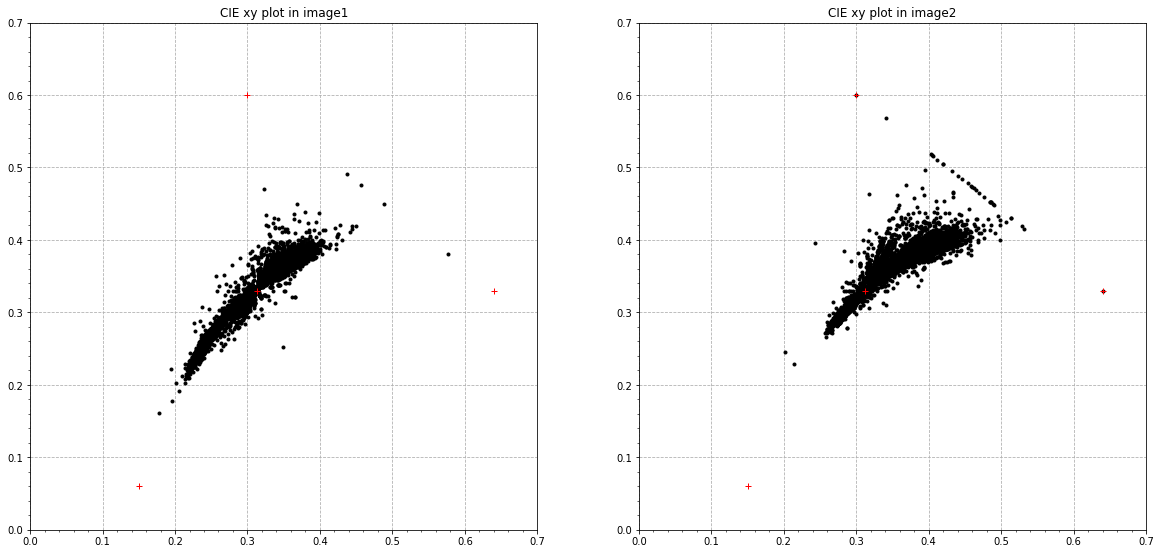

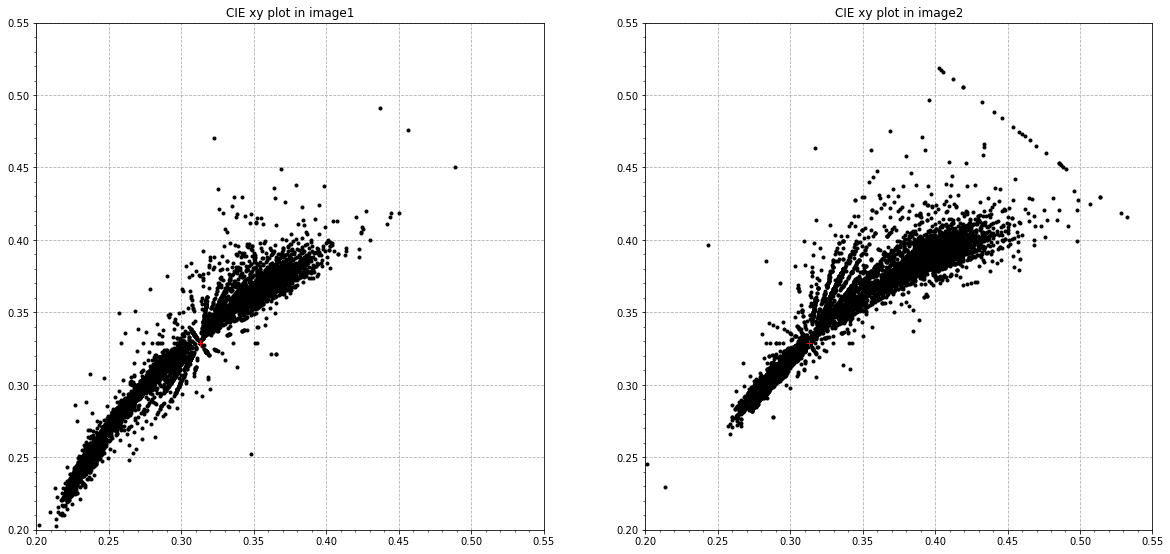

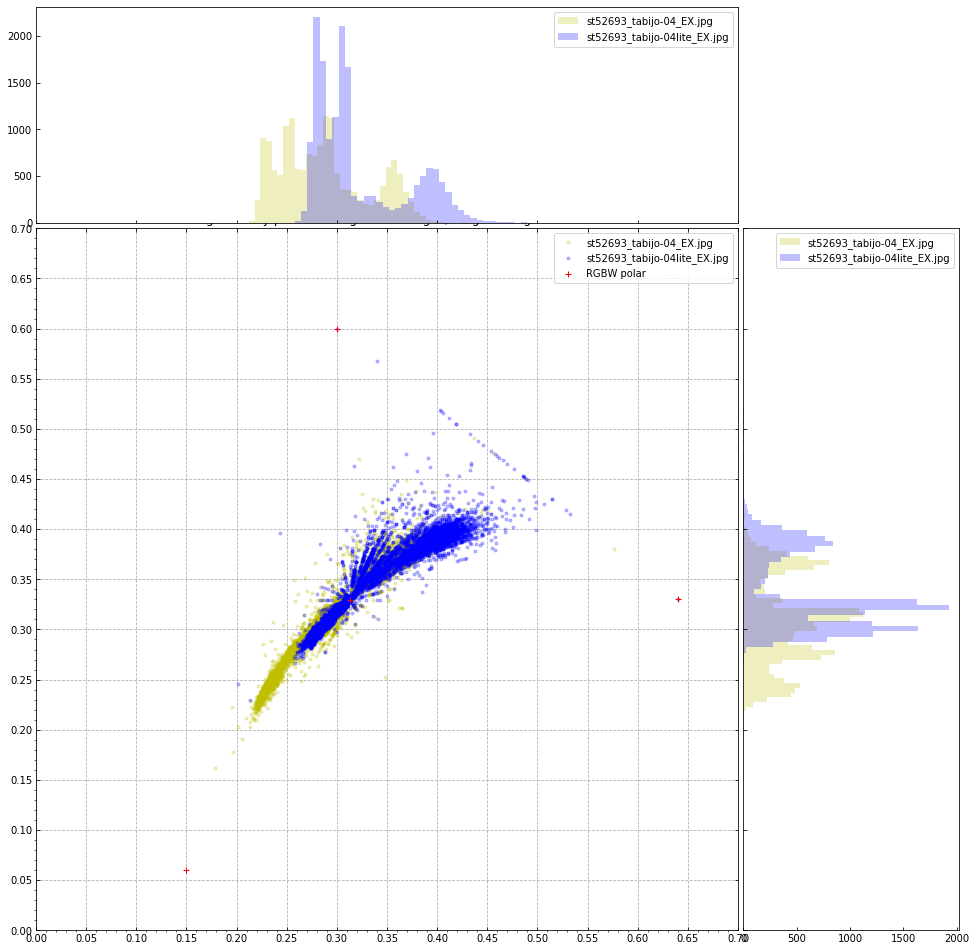

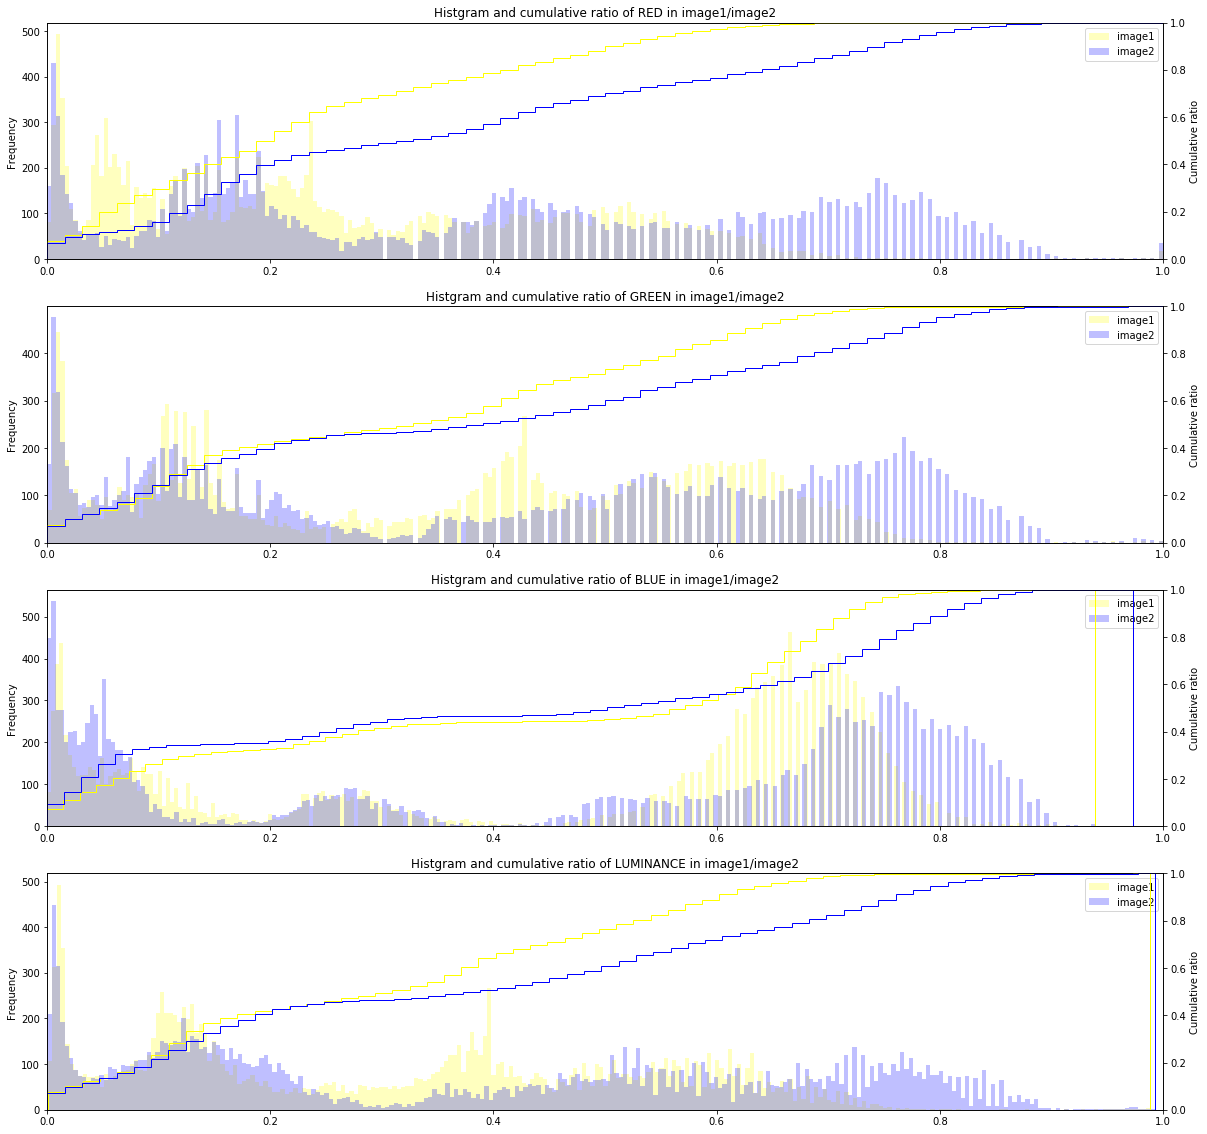

In [5]:
# -*- coding: utf-8 -*-

# import libraries
import sys
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from google.colab import files

CIEXY_RGBW_POLARS = np.array([[0.64, 0.33], [0.30, 0.60], [0.15, 0.06], [0.3127, 0.3290]]) # CIX xyプロット上で固定でプロットする座標(sRGB色空間のR,G,B,Wの極値)
CIEXY_PLOT_X_LIM = (0, 0.7)             # CIE xyプロットの表現範囲でX軸の下限、上限
CIEXY_PLOT_Y_LIM = (0, 0.7)             # CIE xyプロットの表現範囲でY軸の下限、上限
CIEXY_CROPPED_PLOT_X_LIM = (0.2, 0.55)  # CIE xyプロット（切り抜き版）の表現範囲でX軸の下限、上限
CIEXY_CROPPED_PLOT_Y_LIM = (0.2, 0.55)  # CIE xyプロット（切り抜き版）の表現範囲でY軸の下限、上限
CIEXY_MAJOR_LOCATOR = 0.1               # CIE xyプロットのガイド付きのメモリ間隔
CIEXY_CROPPED_MAJOR_LOCATOR = CIEXY_MAJOR_LOCATOR / 2 # CIE xyプロット（切り抜き版）のガイド付きのメモリ間隔
CIEXY_MINOR_LOCATOR_DIVIDER = 5         # ガイド付きのメモリ間隔の間の小メモリの分割数
CIEXY_HIST_BINS = 70                    # CIE xyヒストグラムの分割数、現状プロット表現範囲0～0.7に合わせて0.01の粒度で分割

RGBY_HIST_X_LIM = 0, 1.0                # RGBYヒストグラムの表現範囲でX軸の下限、上限。現状0.0～1.0に正規化しているので0～255にはなっていない
RGBY_HIST_BINS = 256                    # RGBYヒストグラムの分割数。現状正規化しているのであまり意味はないが、正規化前の256段階
RGBY_CUMULATIVE_Y_LIM = 0, 1.0          # RGBYヒストグラムの累積表示の表現範囲でY軸の下限、上限。現状、X軸はヒストグラムと同じため定義せず、Y軸は割合なので0～1.0
RGBY_CUMULATIVE_BINS = int(RGBY_HIST_BINS / 4) # RGBYヒストグラムの累積表示の分割数。現状、ヒストグラムと同じ粒度だとグラフが見え難いこともあったので少し粗目
RGB2Y_CONVERT_MATRIX = np.array([0.299, 0.587, 0.114]) # ITU-R BT.601 に従った輝度Yの変換行列


# Jpeg files load from local PC.
# When not specified 2 jpeg files, it force to end.
!rm *.jpg
uploaded_images = files.upload()

if(len(uploaded_images) != 2):
  print("This program requires 2 image files. So, please retry again.")
  sys.exit(1)

ims = list()
im_fnames = list()
for k, v in uploaded_images.items():
  ims.append(Image.open(k, mode='r'))
  im_fnames.append(k)


def normalizeLinearRgb(originPixel):
  # JPEGを前提として、RGBの各々の解像度8bit(255)と定義
  RGB_RESOLUTION = 255

  # 0～1の間で正規化
  tempPixel = originPixel / RGB_RESOLUTION

  # ガンマ補正を元に戻し、リニア化
  #   正規化値  <= 0.04045 : 正規化値 / 12.92
  #   正規化値  >  0.04045 : ((正規化値 + 0.055) / 1.055) に 2.4階乗
  LINEAR_THR = 0.04045
  return np.piecewise(
      tempPixel,
      [tempPixel <= LINEAR_THR, tempPixel > LINEAR_THR],
      [lambda tempPixel: tempPixel/12.92, lambda tempPixel: ((tempPixel+0.055)/1.055)**2.4])

# convert from normalized RGB to CIE XYZ
def convertToCieXYZ(normalizedRgb):
  # RGB of sRGB color space to CIE XYZ convert matrix
  MATRIX = np.array(
      [[0.412424, 0.357579, 0.180464],
       [0.212656, 0.715158, 0.072186],
       [0.019332, 0.119193, 0.950444]],
       dtype='float32')

  # 画像を１次元に並べ、ループで画素毎にRGBからXYZを算出
  ret_arr = np.empty((0,3), dtype='float32')
  temp = normalizedRgb.reshape(-1, 3)
  (number, _) = temp.shape

  for i in range(number):
    ret_arr = np.append(ret_arr, np.dot(MATRIX, temp[i]).reshape(1,3), axis=0)

  return ret_arr


# convert from CIE XYZ to CIE xyz 
def convertToCiexyz(cieXYZ):
  # ループで画素毎にXYZからxyzを算出
  #   x = X / (X + Y + Z)
  #   y = Y / (X + Y + Z)
  #   z = Z / (X + Y + Z)
  ret_arr = np.empty((0,3), dtype='float32')
  (number, _) = cieXYZ.shape

  for i in range(number):
    xyz = np.array(
        [cieXYZ[i][0]/np.sum(cieXYZ[i]),
         cieXYZ[i][1]/np.sum(cieXYZ[i]),
         cieXYZ[i][2]/np.sum(cieXYZ[i])])
    ret_arr = np.append(ret_arr, xyz.reshape(1,3), axis=0)

  return ret_arr


# plot CIE xy of 2 images
def plotCiexy(
    image1_x, image1_y, image2_x, image2_y,
    x_lim, y_lim, major_locator):
  # ２つのプロット共通パラメータ
  grid_linestyle = "--"
  plot_color =  'black'
  plot_marker = '.'
  plot_linestyle = ''
  plot_transparent_rate = 1.0
  polar_color = 'red'
  polar_marker = '+'
  polar_linestyle = ''

  # image1のプロット
  root_fig = plt.figure(figsize=(20,10))
  image1_plot = root_fig.add_subplot(
      121, title="CIE xy plot in image1",
      xlim=x_lim, ylim=y_lim, aspect='equal')
  image1_plot.xaxis.set_major_locator(MultipleLocator(major_locator))
  image1_plot.yaxis.set_major_locator(MultipleLocator(major_locator))
  image1_plot.grid(linestyle=grid_linestyle, zorder=-10)
  image1_plot.xaxis.set_minor_locator(AutoMinorLocator(CIEXY_MINOR_LOCATOR_DIVIDER))
  image1_plot.yaxis.set_minor_locator(AutoMinorLocator(CIEXY_MINOR_LOCATOR_DIVIDER))
  image1_plot.plot(
      image1_x, image1_y,
      color=plot_color, marker=plot_marker, linestyle=plot_linestyle,
      alpha=plot_transparent_rate, label="image1")
  image1_plot.plot(
      CIEXY_RGBW_POLARS[0:,0], CIEXY_RGBW_POLARS[0:,1],
      color=polar_color, marker=polar_marker, linestyle=polar_linestyle,
      label="RGBW polar")

  # image2 のプロット
  image2_plot = root_fig.add_subplot(
      122, title="CIE xy plot in image2",
      xlim=x_lim, ylim=y_lim, aspect='equal')
  image2_plot.xaxis.set_major_locator(MultipleLocator(major_locator))
  image2_plot.yaxis.set_major_locator(MultipleLocator(major_locator))
  image2_plot.grid(linestyle=grid_linestyle, zorder=-10)
  image2_plot.xaxis.set_minor_locator(AutoMinorLocator(CIEXY_MINOR_LOCATOR_DIVIDER))
  image2_plot.yaxis.set_minor_locator(AutoMinorLocator(CIEXY_MINOR_LOCATOR_DIVIDER))
  image2_plot.plot(
      image2_x, image2_y,
      color=plot_color, marker=plot_marker, linestyle=plot_linestyle,
      alpha=plot_transparent_rate, label="image2")
  image2_plot.plot(
      CIEXY_RGBW_POLARS[0:,0], CIEXY_RGBW_POLARS[0:,1],
      color=polar_color, marker=polar_marker, linestyle=polar_linestyle,
      label="RGBW polar")


def histRgbl(
    image1_r, image1_g, image1_b, image1_l,
    image2_r, image2_g, image2_b, image2_l):
  # ４つのヒストグラムの共通のパラメータ
  HIST_NUM = 4
  IMAGE1_COLOR = 'yellow'
  IMAGE2_COLOR = 'blue'
  HIST_TRANSPARENT_RATE = 0.25

  # ループ処理のためのデータの連結
  image1s = [image1_r, image1_g, image1_b, image1_l]
  image2s = [image2_r, image2_g, image2_b, image2_l]
  TITLES = [
            'Histgram and cumulative ratio of RED in image1/image2',
            'Histgram and cumulative ratio of GREEN in image1/image2',
            'Histgram and cumulative ratio of BLUE in image1/image2',
            'Histgram and cumulative ratio of LUMINANCE in image1/image2'       
  ]

  root_fig = plt.figure(figsize=(20,20))
  for i in range(HIST_NUM):
    # ヒストグラムの描画
    hist1 = root_fig.add_subplot(HIST_NUM, 1, i+1, xlim=RGBY_HIST_X_LIM)
    hist1.set_title(TITLES[i])
    hist1.hist(
        image1s[i], bins=RGBY_HIST_BINS, color=IMAGE1_COLOR,
        alpha=HIST_TRANSPARENT_RATE, label="image1")
    hist1.hist(
        image2s[i], bins=RGBY_HIST_BINS, color=IMAGE2_COLOR,
        alpha=HIST_TRANSPARENT_RATE, label="image2")
    hist1.set_ylabel('Frequency')
    hist1.legend()

    # 累計の割合をヒストグラムと同根で描画
    hist2 = hist1.twinx()
    hist2.set_xlim(hist2.get_xlim())
    hist2.set_ylim(RGBY_CUMULATIVE_Y_LIM)
    hist2.hist(
        image1s[i], bins=RGBY_CUMULATIVE_BINS, cumulative=True, density=True,
        histtype='step', color=IMAGE1_COLOR)
    hist2.hist(
        image2s[i], bins=RGBY_CUMULATIVE_BINS, cumulative=True, density=True,
        histtype='step', color=IMAGE2_COLOR)
    hist2.set_ylabel('Cumulative ratio')
      


# 画像データの前処理
ciexyzs = list()
normalizedRGBs = list()
for im in ims:
  print(im.size, im.mode)
  im_list = np.asarray(im)

  # 画像の間引き：とりあえず、XGA以上の解像度を想定し、横幅1024未満にする間引き
  MAX_IMG_WIDTH = 1024
  (img_x, img_y, img_dim) = im_list.shape
  if img_x  > img_y:
    skip = int(img_x / MAX_IMG_WIDTH) + 1
  else:
    skip = int(img_y / MAX_IMG_WIDTH) + 1

  # 処理時間がかかるため、追加で固定値で間引き
  skip *= 4
  im_list2 = im_list[::skip,::skip,::]

  # RGB to CIE xyz
  normalizedRGB = normalizeLinearRgb(im_list2)
  normalizedRGBs.append(normalizedRGB)
  cieXYZ = convertToCieXYZ(normalizedRGB)
  ciexyzs.append(convertToCiexyz(cieXYZ))

# プロット用にCIE xyとRGBLのデータ抽出
image1_x = ciexyzs[0][0:, 0]
image1_y = ciexyzs[0][0:, 1]
image2_x = ciexyzs[1][0:, 0]
image2_y = ciexyzs[1][0:, 1]
temp = normalizedRGBs[0].reshape(-1, 3)
image1_r = temp[0:, 0]
image1_g = temp[0:, 1]
image1_b = temp[0:, 2]
image1_l = np.dot(temp[0:,], RGB2Y_CONVERT_MATRIX)
temp = normalizedRGBs[1].reshape(-1, 3)
image2_r = temp[0:, 0]
image2_g = temp[0:, 1]
image2_b = temp[0:, 2]
image2_l = np.dot(temp[0:,], RGB2Y_CONVERT_MATRIX)
image1_filename = im_fnames[0]
image2_filename = im_fnames[1]


# プロット1 CIE xyのプロット、画像毎にプロット
plotCiexy(
    image1_x, image1_y, image2_x, image2_y,
    CIEXY_PLOT_X_LIM, CIEXY_PLOT_Y_LIM,
    CIEXY_MAJOR_LOCATOR)

# プロット3 CIE xyのプロット、画像2つのセパレートの局所ズーム版
plotCiexy(
    image1_x, image1_y, image2_x, image2_y,
    CIEXY_CROPPED_PLOT_X_LIM, CIEXY_CROPPED_PLOT_X_LIM,
    CIEXY_CROPPED_MAJOR_LOCATOR)


# プロット4 CIE xyのプロット、画像2つの合同プロット拡大版＋xとy毎のヒストグラム
fig4 = plt.figure(figsize=(15,15))
LEFT, WIDTH = 0.1, 0.65
BOTTOM, HEIGHT = 0.1, 0.65
SPACING = 0.005
RECT_SCATTER = [LEFT, BOTTOM, WIDTH, HEIGHT]
RECT_HISTX = [LEFT, BOTTOM + HEIGHT + SPACING, WIDTH, 0.2]
RECT_HISTY = [LEFT + WIDTH + SPACING, BOTTOM, 0.2, HEIGHT]
ax_plot7 = fig4.add_axes(RECT_SCATTER)
ax_plot7.tick_params(direction='in', top=True, right=True)
ax_hist1 = fig4.add_axes(RECT_HISTX)
ax_hist1.tick_params(direction='in', labelbottom=False)
ax_hist2 = fig4.add_axes(RECT_HISTY)
ax_hist2.tick_params(direction='in', labelleft=False)

ax_plot7.set_title('Enlarged CIE xy plot and histgram in image1/image2 using linear RGB')
ax_plot7.set_xlim(CIEXY_PLOT_X_LIM)
ax_plot7.set_ylim(CIEXY_PLOT_Y_LIM)
ax_plot7.xaxis.set_major_locator(MultipleLocator(CIEXY_CROPPED_MAJOR_LOCATOR))
ax_plot7.yaxis.set_major_locator(MultipleLocator(CIEXY_CROPPED_MAJOR_LOCATOR))
ax_plot7.grid(linestyle="--", zorder=-10)
ax_plot7.xaxis.set_minor_locator(AutoMinorLocator(CIEXY_MINOR_LOCATOR_DIVIDER))
ax_plot7.yaxis.set_minor_locator(AutoMinorLocator(CIEXY_MINOR_LOCATOR_DIVIDER))
ax_plot7.set_aspect('equal')
#ax_plot7.scatter(image1_x, image1_y)
ax_plot7.plot(image1_x, image1_y, 'y.', alpha=0.25, label=image1_filename)
ax_plot7.plot(image2_x, image2_y, 'b.', alpha=0.25, label=image2_filename)
ax_plot7.plot(CIEXY_RGBW_POLARS[0:,0], CIEXY_RGBW_POLARS[0:,1], "r+", label="RGBW polar")
ax_plot7.legend()
ax_hist1.set_xlim(ax_plot7.get_xlim())
ax_hist1.hist(image1_x, bins=CIEXY_HIST_BINS, color='y', alpha=0.25, label=image1_filename)
ax_hist1.hist(image2_x, bins=CIEXY_HIST_BINS, color='b', alpha=0.25, label=image2_filename)
ax_hist1.legend()
ax_hist2.set_ylim(ax_plot7.get_ylim())
ax_hist2.hist(image1_y, bins=CIEXY_HIST_BINS, color='y', alpha=0.25, label=image1_filename, orientation='horizontal')
ax_hist2.hist(image2_y, bins=CIEXY_HIST_BINS, color='b', alpha=0.25, label=image2_filename, orientation='horizontal')
ax_hist2.legend()

histRgbl(
    image1_r, image1_g, image1_b, image1_l,
    image2_r, image2_g, image2_b, image2_l
)
plt.show()